In [1]:
from src.ml import *

dataset = process_raw_data(year_start=2017)
dataset = create_features(dataset)

dropping 755 duplicates
dropping 1135 rows for 2017 year start
ds shape: (3737, 5)


In [2]:
dataset.head()

,headline,claps,site_id,year,site,binned-class,log-claps,clip-claps,n-characters,n-words
0,Install Tensorflow 1.13 on Ubuntu 18.04 with G...,588.0,better-programming,2019,better-programming,1.0,6.376727,588.0,56,9
1,Authentication and Authorization using JWT wit...,1300.0,better-programming,2019,better-programming,1.0,7.170120,1300.0,55,7
2,Authentication and Authorization using Redis,1300.0,better-programming,2019,better-programming,1.0,7.170120,1300.0,44,5
3,Linux: A Survival Guide for Beginners,1100.0,better-programming,2019,better-programming,1.0,7.003065,1100.0,37,6
4,How To Properly Use the React useRef Hook in C...,295.0,better-programming,2019,better-programming,0.0,5.686975,295.0,60,11


In [27]:
grps = dataset.groupby('site_id').mean().loc[:, 'claps'].to_frame()
grps = grps.to_dict()['claps']

dataset.loc[:, 'site_id'].replace(grps)

0       2959.887755
1       2959.887755
2       2959.887755
3       2959.887755
4       2959.887755
           ...     
5612    5380.182058
5613    5380.182058
5614    5380.182058
5615    5380.182058
5616    5380.182058
Name: site_id, Length: 3737, dtype: float64

In [4]:
dataset.sort_values('claps', ascending=False)

,headline,claps,site_id,year,site,binned-class,log-claps,clip-claps,n-characters,n-words
3497,The Most Important Skill Nobody Taught You,294000.0,personal-growth,2018,personal-growth,3.0,12.591335,80000.0,42,7
3210,Travel Is No Cure for the Mind,271000.0,personal-growth,2018,personal-growth,3.0,12.509874,80000.0,30,7
3211,The 3 Keys to Becoming Irresistible,238000.0,personal-growth,2018,personal-growth,3.0,12.380026,80000.0,35,6
534,Im harvesting credit card numbers and password...,226000.0,hackernoon,2018,hackernoon,3.0,12.328290,80000.0,74,12
1696,How to think like a programmerlessons in probl...,210000.0,free-code-camp,2018,free-code-camp,3.0,12.254863,80000.0,56,9
...,...,...,...,...,...,...,...,...,...,...
3822,Featured Articles (October 2531),1.0,personal-growth,2020,personal-growth,0.0,0.000000,1.0,32,4
856,Five Tech Stories,1.0,hackernoon,2020,hackernoon,0.0,0.000000,1.0,17,3
833,"AMA with Rana Gujral, CEO of Behavioral Signal...",1.0,hackernoon,2020,hackernoon,0.0,0.000000,1.0,96,17
831,Emoji Reactions,1.0,hackernoon,2020,hackernoon,0.0,0.000000,1.0,17,4


## Clap statistics

In [5]:
dataset['claps'].describe()

count      3737.000000
mean       5537.296227
std       13656.285019
min           1.000000
25%         473.000000
50%        1800.000000
75%        5800.000000
max      294000.000000
Name: claps, dtype: float64

## Distribution of claps

<AxesSubplot:ylabel='Frequency'>

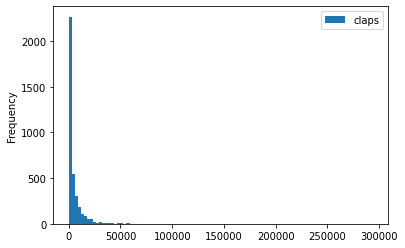

In [6]:
dataset.plot(y='claps', kind='hist', bins=100)

## Distribution of clipped claps

<AxesSubplot:ylabel='Frequency'>

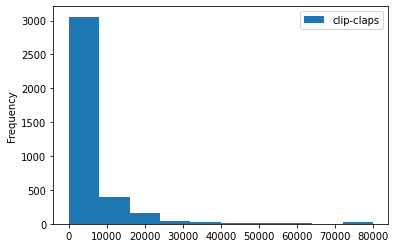

In [7]:
dataset.plot(y='clip-claps', kind='hist')

## Distribution of log claps

<AxesSubplot:ylabel='Frequency'>

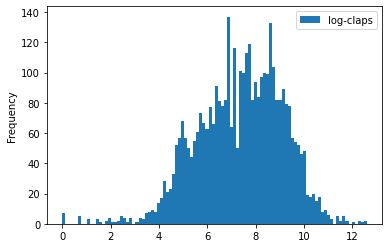

In [8]:
dataset.plot(y='log-claps', kind='hist', bins=100)

<AxesSubplot:ylabel='Frequency'>

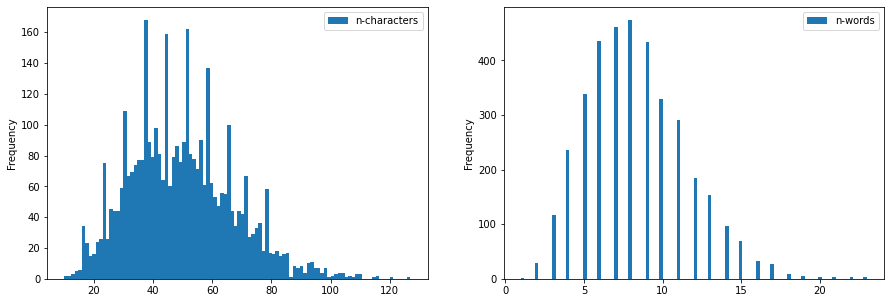

In [9]:
f, axes = plt.subplots(ncols=2, figsize=(15, 5))
dataset.plot(ax=axes[0], y='n-characters', kind='hist', bins=100)
dataset.plot(ax=axes[1], y='n-words', kind='hist', bins=100)

## Binning the claps

In [10]:
target = dataset.groupby('binned-class').count().loc[:, 'headline']
target

binned-class
0.0    934
1.0    917
2.0    943
3.0    943
Name: headline, dtype: int64

<AxesSubplot:xlabel='binned-class'>

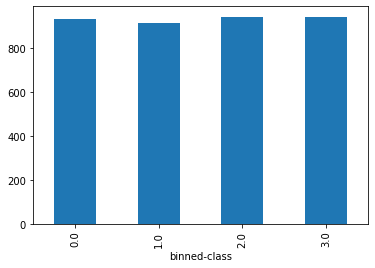

In [11]:
target.plot(kind='bar')

## How do claps change over time?

In [12]:
years = dataset.groupby('year').agg({'claps': ['median', 'mean']})
years.columns = years.columns.get_level_values(1)
years

,median,mean
year,,
2017,1930.0,5475.133259
2018,3400.0,9211.110384
2019,1300.0,3371.572844
2020,1200.0,3335.493473


<AxesSubplot:xlabel='year'>

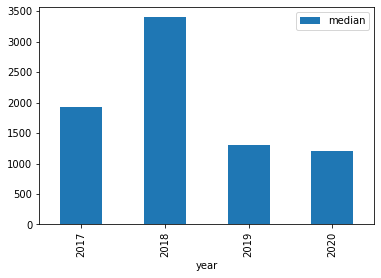

In [13]:
years.plot(kind='bar', y='median')

## By site

In [14]:
sites = dataset.groupby('site_id').agg({'claps': ['median', 'mean']})
sites.columns = sites.columns.get_level_values(1)
sites

,median,mean
site_id,,
better-programming,1600.0,2959.887755
dailyjs,503.0,1399.757785
free-code-camp,8700.0,14791.050847
hackernoon,2400.0,7337.274238
level-up-web,174.0,393.182768
levelup,691.0,1329.846966
personal-growth,5000.0,9634.774403
swlh,3000.0,7320.485588
the-mission,1300.0,5380.182058


## By site and year

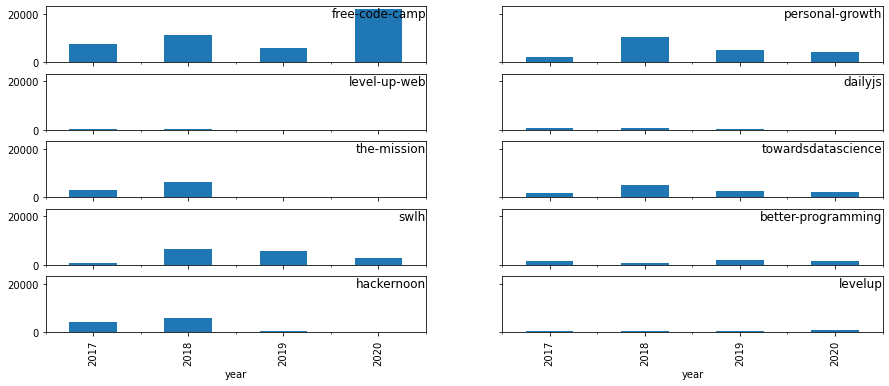

In [15]:
from math import ceil

sites = list(set(dataset['site_id']))
f, axes = plt.subplots(ncols=2, nrows=ceil(len(sites) / 2), sharex=True, sharey=True, figsize=(15, 6))

for site, ax in zip(sites, axes.flatten()):
    mask = dataset.loc[:, 'site_id'] == site
    subset = dataset.loc[mask, :]
    grp = subset.groupby('year').agg({'claps': 'median'})
    grp.plot(ax=ax, kind='bar')
    ax.get_legend().remove()
    ax.set_title(site, loc='right', y=0.7)

## Headline features

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

vec = CountVectorizer()
x = vec.fit_transform(dataset['headline'])
x = x.todense()
print(x.shape)

(3737, 4891)


In [17]:
names = np.array(vec.get_feature_names())
counts = np.squeeze(np.array(x.sum(axis=0)))

In [18]:
counts[:10]

array([ 17,   1,   5, 124,  17,   1,   1,   1,   8,   1])

In [19]:
sort_idx = np.squeeze(np.array(counts.argsort()))

In [20]:
counts[sort_idx][-32:]

array([ 104,  107,  107,  109,  120,  124,  131,  131,  135,  137,  138,
        138,  146,  151,  159,  160,  161,  166,  176,  205,  234,  256,
        384,  409,  456,  478,  492,  628,  680,  691,  881, 1333])

In [21]:
names[sort_idx][-32:]

array(['learn', 'js', 'web', 'app', 'should', '10', 'best', 'data',
       'from', 'technical', 'life', 'using', 'learning', 'on', 'an',
       'javascript', 'that', 'python', 'what', 'why', 'is', 'react',
       'with', 'for', 'your', 'you', 'of', 'and', 'in', 'how', 'the',
       'to'], dtype='<U43')